# Introduction, data cleaning and EDA

In [7]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB

train_raw = pd.read_csv("BBC News Train.csv")

test_raw = pd.read_csv("BBC News Test.csv")

train_raw['Text'] = train_raw['Text'].astype("string")
test_raw['Text'] = test_raw['Text'].astype("string")

The code above simply handles all necessary imports and loads the data. The only cleaning/transformation needed is to make sure the text data is represented as a string. Below are some histograms/plots to visualize the data.

Text(0.5, 1.0, 'Number of words in articles in train set')

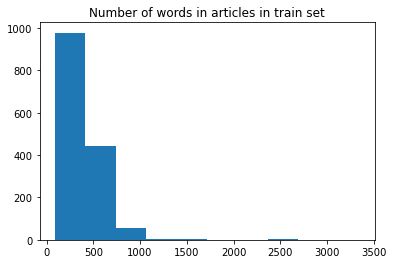

In [27]:
text_lengths = []
for text in train_raw['Text']:
    text_lengths.append(len(text.split()))
plt.hist(text_lengths)
plt.title("Number of words in articles in train set")

Below are a few helper functions to perform model training and analysis:

In [2]:
def getLabelOrder(transformed):
#method to determine which label in the model goes with which topic
    
    yp_ind = []

    for transf in transformed:
        m = 0
        i = 0
        for index, val in enumerate(transf):
            if val > m:
                m = val
                i = index
        yp_ind.append(i)

    perms = itertools.permutations((0,1,2,3,4))

    max_acc = 0

    for perm in perms:
        yp_try = []
        label_dict = dict()
        label_dict[perm[0]] = 'business'
        label_dict[perm[1]] = 'entertainment'
        label_dict[perm[2]] = 'politics'
        label_dict[perm[3]] = 'sport'
        label_dict[perm[4]] = 'tech'
    
        for label in yp_ind:
            yp_try.append(label_dict[label])
    
        acc = accuracy_score(train_raw['Category'], yp_try)
        if acc > max_acc:
            max_acc = acc
            max_perm = perm
    
    yp_lab, label_dict = assignLabels(yp_ind, max_perm)

    return max_perm, max_acc, yp_lab, label_dict

In [3]:
def assignLabels(yp_ind, order):
#create label dictionary based on order determined by getLabelOrder
    label_dict = dict()
    label_dict[order[0]] = 'business'
    label_dict[order[1]] = 'entertainment'
    label_dict[order[2]] = 'politics'
    label_dict[order[3]] = 'sport'
    label_dict[order[4]] = 'tech'
    yp_lab= []
    for lab in yp_ind:
        yp_lab.append(label_dict[lab])
    confusion_matrix(train_raw['Category'], yp_lab)
    return yp_lab, label_dict

In [4]:
def predict(transformed, label_dict):
#given a label dictionary and transformed data, return a list of appropriate labels (topics)
    yp_ind = []

    for transf in transformed:
        m = 0
        i = 0
        for index, val in enumerate(transf):
            if val > m:
                m = val
                i = index
        yp_ind.append(i)

    yp_lab = []
    for lab in yp_ind:
        yp_lab.append(label_dict[lab])
    
    return yp_lab

In [5]:
def toCsv(data, num):
#output a list of labels to a .csv file which can be uploaded to kaggle to determine accuracy on the test set
    df = pd.DataFrame()
    df['ArticleId'] = test_raw['ArticleId']
    df['Category'] = data
    df.to_csv(f'output{num:d}.csv', index=False)

# Model training and analysis

The code below will vectorize the raw text data. I am using TF-IDF. This a method that counts the number of times a word appears in a document and compares it to the total number of documents that word appears in to get a better idea of just how important that word is.

In [6]:
train_acc = []
for i in range(1,11):    
    tfidf_vectorizer = TfidfVectorizer(max_features=i*100, stop_words="english")
    X_train_tfidf = tfidf_vectorizer.fit_transform(train_raw['Text'])
    X_test_tfidf = tfidf_vectorizer.fit_transform(test_raw['Text'])

    nmf = NMF(n_components=5, max_iter=1000).fit(X_train_tfidf)

    transformedtrain = nmf.transform(X_train_tfidf)
    transformedtest = nmf.transform(X_test_tfidf)

    order, acc, trainy_lab, label_dict = getLabelOrder(transformedtrain)
    train_acc.append(acc)
    testy_lab = predict(transformedtest, label_dict)

    toCsv(testy_lab, i)

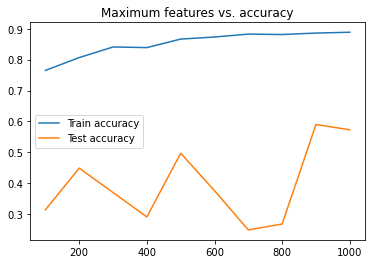

In [15]:
test_acc = [0.314, 0.449, 0.370, 0.291, 0.497, 0.376, 0.249, 0.268, 0.590, 0.573]

max_features = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

plt.plot(max_features, train_acc, label="Train accuracy")
plt.plot(max_features, test_acc, label="Test accuracy")
plt.title("Maximum features vs. accuracy")
plt.legend()

The graph above shows the train and test accuracy for the max_features parameter, which is part of the TF-IDF process. The max_features determines how many words to consider as significant in the model; for instance, if it is $100$, that means only the $100$ most frequent words will be used to classify the text.

Train accuracy steadily improves as max_features increases, but test accuracy is more variable, reaching its highest point at $900$.

In [24]:
tfidf_vectorizer = TfidfVectorizer(max_features=900, stop_words="english")
X_train_tfidf = tfidf_vectorizer.fit_transform(train_raw['Text'])
X_test_tfidf = tfidf_vectorizer.fit_transform(test_raw['Text'])

clf = MultinomialNB().fit(X_train_tfidf, train_raw['Category'])

print("Train accuracy for\nBayes: %f" % clf.score(X_train_tfidf, train_raw['Category']))
print("NMF: %f" % train_acc[8])

toCsv(clf.predict(X_test_tfidf), 11)

Train accuracy for
Bayes: 0.970470
NMF: 0.885906


For the supervised learning method, I chose a naive Bayes classifier. Training accuracy for naive Bayes ($0.970$) was superior to NMF ($0.886$). However, test accuracy was identical for both ($0.590$).

# References

Duque, T. (2020, November 13). How to turn text into features. Towards Data Science. Retrieved June 21, 2022, from https://towardsdatascience.com/how-to-turn-text-into-features-478b57632e99 